In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.050134  0.618401 -0.628499 -0.642755 -0.981115  0.721251  0.850535   
  1   0.646067 -0.548544 -0.743401  0.362886 -0.069619  0.591778  0.336027   
  2   0.387115  0.290133 -0.507794 -0.459322 -0.441135  0.442030  0.103499   
  3   0.082103 -0.736229 -0.084262 -0.110642 -0.055398  0.609342  0.226495   
  4  -0.071376  0.278020 -0.659704 -0.460281 -0.457941  0.962700  0.368105   
  5   0.757462 -1.411767 -0.640934 -0.216785 -0.755935  0.048161  0.070523   
  6   0.136155  0.968864  0.568520 -1.280301 -0.524881  0.098494  0.731284   
  7  -0.537082  0.273743  0.273223  0.502289 -0.752829  0.989679  0.345685   
  8  -0.002211 -1.021379 -0.837652 -0.822017 -1.001660  0.469525  0.051427   
  9  -0.623617  0.997463  0.464650 -0.636637  0.947289  1.365454  0.496903   
  10  0.118687 -0.281583 -0.328263 -1.188258 -0.306620 -0.747339  0.164632   
  11  0.132984  0.583326  0.396940 -0.053914 -0.153831  1.008775  1.050801   
  12 -0.004238 -0.319109 -0.820427 -0.100845  0.565840  1.795638  1.466312   
  13  0.821847 -0.288370 -1.204113 -0.362060 -1.048772  0.926625  0.803970   
  14 -0.019917  0.313429 -0.392929  0.151737 -0.363728  1.290636  1.138813   
  15  0.257532  0.795799 -0.272510 -0.346004  0.497648  0.253550  0.525101   
  16 -0.001856  0.225792 -0.775569  0.259795  0.734234  1.022719  1.063782   
  17  0.823520  0.601254 -0.702125 -0.216347 -0.022699  0.341863 -0.407197   
  18 -0.666617 -0.361108  0.020866 -0.153698 -0.706929 -0.187309  0.896874   
  19  0.380529  0.258710  0.698043  0.167987 -0.132694  1.644600 -1.035028   
  20  0.558245  0.044074 -0.834689 -0.440895 -0.154333  0.268795  0.378562   
  21 -0.202349  0.055636  0.552420  0.186168  0.165882  0.383191 -0.464911   
  22  0.913976  0.593410 -0.368478 -0.223963 -0.806010  0.627520  0.307288   
  23  0.081305  0.568702  0.252137  0.275066 -0.105468  1.056993 -0.162157   
  24  0.235417 -0.744287 -0.247390  0.294389  0.257303  1.580509  0.286729   
1 0   0.776549  0.943801 -0.505530 -0.179657 -0.968868 -0.404203 -0.742192   
  1   0.235982  0.247293  0.486836  0.204200 -0.024670 -0.070349 -0.434963   
  2  -0.544527  0.226864 -0.292401 -0.134916  0.152746  0.304602 -0.853514   
  3  -0.291450 -0.327136  0.255392 -0.514704  0.609875  0.324671  0.690972   
  4  -0.075903  0.601329 -0.354551 -0.554070 -0.527412 -0.080229  0.937840   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.211830  0.793078  0.109380  ...  0.403202 -0.357503 -0.392035   
  1   0.504216 -0.083496  0.282078  ... -0.985602 -0.491959 -0.054976   
  2  -0.663266  0.125764  0.505205  ... -0.826390  0.097105  0.016868   
  3  -0.228693 -0.311156  0.670800  ...  0.134420  0.070598  0.683906   
  4  -0.155875 -0.349179 -0.261738  ... -0.268277  0.063443  0.348356   
  5  -1.218515 -0.071979  0.113294  ... -1.278371  0.017901  0.153213   
  6   0.197380  0.102341  0.697149  ... -0.281654 -0.031193 -0.809715   
  7   0.369314 -0.002083  0.665991  ...  0.036383  0.451859  0.165843   
  8  -0.686371 -0.570340 -0.453145  ... -1.081194 -0.178659  0.533821   
  9  -0.501533 -0.196368  0.526506  ... -0.168722  0.072833  0.466939   
  10  0.052729  0.897546  0.402659  ... -1.209081  0.063198 -0.769659   
  11  0.163690 -0.628078 -0.744258  ... -0.312467 -1.233273 -0.287753   
  12  0.178344  0.338003 -0.860481  ...  0.081463 -0.026373 -0.138243   
  13 -0.015266  0.146379 -0.203322  ... -0.484792 -0.861740  0.518439   
  14 -0.289759  0.953215  0.184036  ... -0.697831  0.122049  0.100352   
  15 -0.264739  0.513074  0.831155  ... -0.683512 -1.098155 -0.592699   
  16  0.072785  0.144538  1.081459  ... -0.523945 -0.112390  0.813479   
  17 -0.110347 -0.088390  0.380675  ...  0.455202 -0.645598 -0.004059   
  18 -0.378531 -1.230903 -1.582162  ... -0.650587 -0.790140 -0.528975   
  19 -0.429559 -0.824312 -0.114963  ... -0.377338  0.238703 -0.242811   
  20 -1.156597  0.062093 -0.378611  ... -0.420520  0.477430 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

      coef   std err          t          P>|t|     2.5 %    97.5 %
D  0.99141  0.039966  24.806083  7.707451e-136  0.913078  1.069743


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



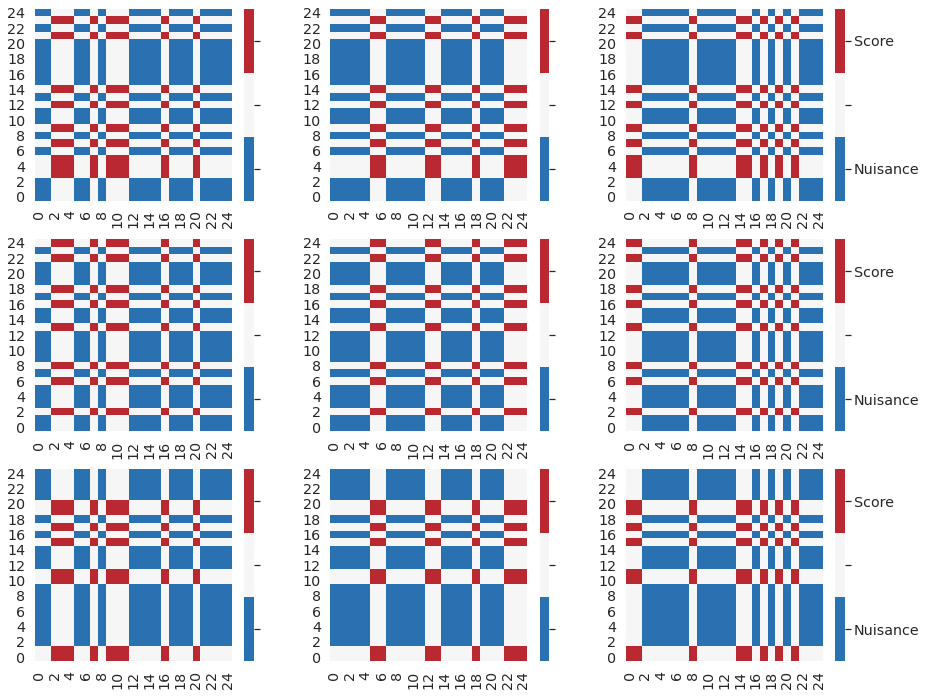

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



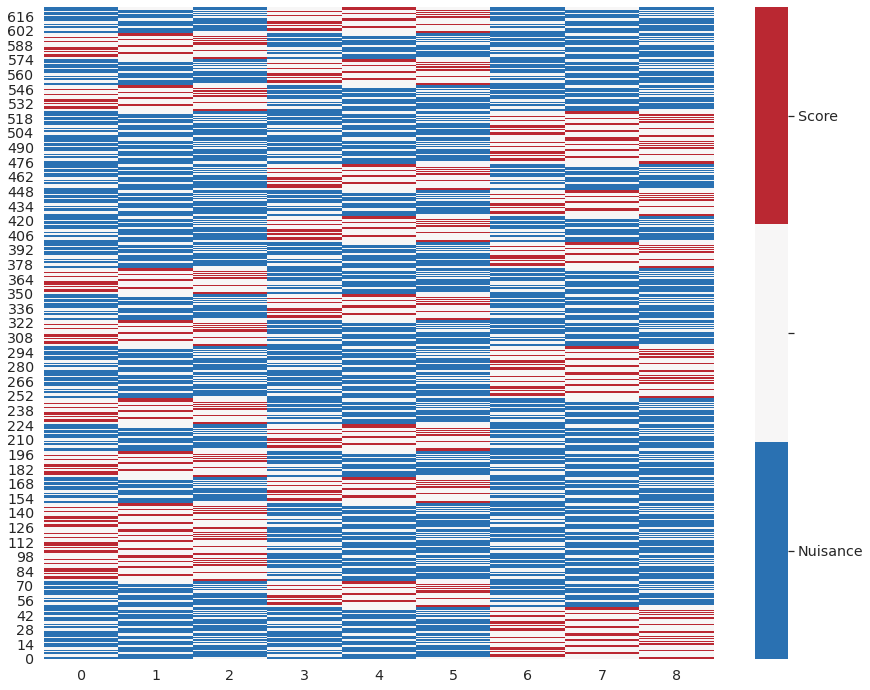

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])